<center>
<h1>Programming Exercise 3:<br>Multi-class Classification and Neural Networks<br></h1>
<h2>Machine Learning<br></h2>
</center>

# Introduction

In this exercise, you will implement one-vs-all logistic regression and neural
networks to recognize hand-written digits. Before starting the programming
exercise, we strongly recommend watching the video lectures and completing
the review questions for the associated topics.

In [1]:
# Library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from scipy import optimize

%matplotlib inline

In [2]:
# Submission

import mlcourse.submission
submit = mlcourse.submission.create_submission('ex3')

login_email = 'example@example.com'
submission_token = 'SUBMISSIONTOKEN'

In [3]:
# Helper functions

def sigmoid(z):
    g = 1/(1 + np.exp(-1*z))
    return g

def display_data(X):
    """
    Displays 2D data stored in X in a nice grid.
    """
    
    padding = 1
    
    m, n = X.shape
    
    plot_width = int(np.ceil(np.sqrt(m)))
    data_width = int(np.ceil(np.sqrt(n)))
    
    grid_size = plot_width*data_width + (plot_width+1)*padding
    image_grid = np.zeros((grid_size, grid_size)) - 0.2
    
    assert data_width*data_width == n, "Data images must be square!"
    
    im_counter = 0
    
    for rw in range(plot_width):
        for cl in range(plot_width):
            if im_counter == m:
                break
            else:
                loc_x = padding + (data_width + padding)*rw
                loc_y = padding + (data_width + padding)*cl
                image_grid[loc_x:loc_x+data_width, loc_y:loc_y+data_width] = \
                    X[im_counter].reshape((data_width, data_width))
                im_counter += 1
    
    plt.imshow(image_grid.T, cmap='gray')   
    plt.axis('off')

# Multi-class Classification

For this exercise, you will use logistic regression and neural networks to
recognize handwritten digits (from 0 to 9). Automated handwritten digit
recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This
exercise will show you how the methods you've learned can be used for this
classification task.

In the first part of the exercise, you will extend your previous implemention
of logistic regression and apply it to one-vs-all classification.

## Dataset

You are given a data set in `./data/ex3/ex3data1.mat` that contains 5000 training examples
of handwritten digits [^1]. The `.mat` format means that that the data has
been saved in a native Octave/MATLAB matrix format, instead of a text
(ASCII) format like a csv-file. These matrices can be read directly into your
program by using the `scipy.io.loadmat()` method. After loading, matrices of the correct
dimensions and values will appear in your program in a dictionary.
The keys for this dictionary contain the variable names for the matrices and you should
assign them to variables.

```python
    # Load Training Data
    print('Loading and Visualizing Data ...\n')
    data = scipy.io.loadmat('./data/ex3/ex3data1.mat')

    # Assign names to the matrices in the dictionary.
    X = data['X']
    y = data['y']
```

There are 5000 training examples in `ex3data1.mat`, where each training
example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is
represented by a floating point number indicating the grayscale intensity at
that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional
vector. Each of these training examples becomes a single row in our data
matrix $X$. This gives us a 5000 by 400 matrix `X` where every row is a training
example for a handwritten digit image.

$$
X =
\left[\begin{matrix}- (x^{(1)})^T - \\- (x^{(2)})^T - \\\vdots\\- (x^{(m)})^T - \end{matrix}\right]
$$

The second part of the training set is a 5000-dimensional vector `y` that
contains labels for the training set. The orignal version of this exercise
was based on Octave/MATLAB and used the label "10" to reprsent the digit zero.
Since indexing in Python starts from zero (as opposed to one in Octave/MATLAB)
we change all the "10" labels back to "0" by performing a simple search and
replace on the array `y`.

```python
    y[np.where(y==10)[0]] = 0
```

## Visualizing the data

You will begin by visualizing a subset of the training set. In next cell,
the code randomly selects selects 100 rows from `X` and passes those rows
to the `display_data()` function. This function maps each row to a 20 pixel by
20 pixel grayscale image and displays the images together. We have provided
the `display_data` function (at the top of this notebook right after the imports),
and you are encouraged to examine the code to see how it works. After you run this
step, you should see an image like Figure 1.

<center>
<img src="./figs/ex3_fig1.png">
Figure 1: Examples from the data set.
</center>

<br>

---

<b>1:</b> This is a subset of the MNIST handwritten digit dataset <http://yann.lecun.com/exdb/mnist/>.

Loading and Visualizing Data...



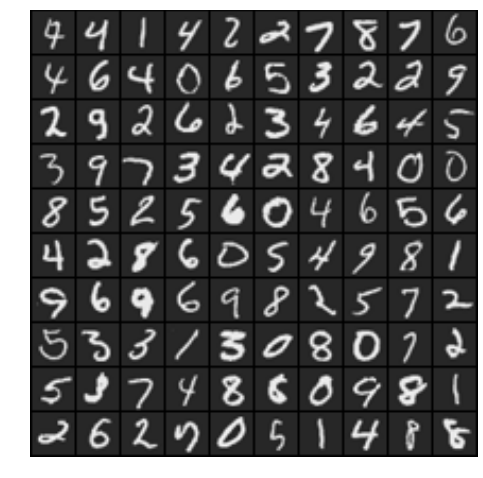

In [4]:
## Setup the parameters you will use for this part of the exercise

# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 0 to 9
num_labels = 10;          
                          
## Loading and Visualizing Data
#  We start the exercise by first loading and visualizing the dataset. 
#  You will be working with a dataset that contains handwritten digits.

# Load Training Data
print('Loading and Visualizing Data...\n')
data = scipy.io.loadmat('./data/ex3/ex3data1.mat')

# training data stored in arrays X, y
X = data['X']
y = data['y']

# The `.m` file used the label '10' for '0'; change that back.
# (we don't care about MATLAB compatibility anymore. ha!)
y[np.where(y==10)[0]] = 0

m = X.shape[0]

# Randomly select 100 data points to display
rand_indices = np.random.permutation(m)
sel = X[rand_indices[:100], :]

plt.figure(figsize=(8, 8))
display_data(sel)
# plt.savefig('./figs/ex3_fig1.png')

## Vectorizing Logistic Regression

You will be using multiple one-vs-all logistic regression models to build a
multi-class classifier. Since there are 10 classes, you will need to train 10
separate logistic regression classifiers. To make this training efficient, it is
important to ensure that your code is well vectorized. In this section, you
will implement a vectorized version of logistic regression that does not employ
any for loops. You can use your code in the last exercise as a starting point
for this exercise.

### Vectorizing the cost function

We will begin by writing a vectorized version of the cost function. Recall
that in (unregularized) logistic regression, the cost function is

$$J(\theta) = \dfrac{1}{m} \sum_{i = 1}^{m} \left[-y^{(i)}\log{(h_\theta(x^{(i)}))} -(1-y^{(i)})\log{(1- h_\theta(x^{(i)}))} \right],$$

To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for 
every example $i$, where $h_\theta(x^{(i)}) = g(\theta^Tx^{(i)})$ and
$g(z) = \dfrac{1}{1 + e^{-z}}$ is the sigmoid function. It turns out that we can
compute this quickly for all our examples by using matrix multiplication.
Let us define $X$ and $\theta$ as

$$
X =
\left[\begin{matrix} - (x^{(1)})^T - \\- (x^{(2)})^T - \\\vdots\\- (x^{(m)})^T - \end{matrix}\right]
\quad
\text{ and }
\quad
\theta = 
\left[\begin{matrix}\theta_0\\\theta_1\\\vdots\\\theta_n\end{matrix}\right]
$$

Then, by computing the matrix product $X\theta$, we have

$$
X =
\left[\begin{matrix} - (x^{(1)})^T\theta - \\- (x^{(2)})^T\theta - \\\vdots\\- (x^{(m)})^T\theta - \end{matrix}\right] = 
\left[\begin{matrix} - \theta^T(x^{(1)}) - \\- \theta^T(x^{(2)}) - \\\vdots\\- \theta^T(x^{(m)}) - \end{matrix}\right]
$$

In the last equality, we used the fact that $a^Tb = b^Ta$ is $a$ and $b$ are vectors.
This allows us to compute the products $\theta^Tx^{(i)}$ for all our examples $i$ in one
line of code.

Your job is to write the unregularized cost function in the function `lr_cost_function()`
Your implementation should use the strategy we presented above to calculate $\theta^Tx^{(i)}$.
You should also use a vectorized approach for the rest of the
cost function. A fully vectorized version of `lr_cost_function()` should not
contain any loops.

> **Hint**:

> You might want to use the element-wise multiplication operation
> `*` and the sum operation `np.sum()` when writing this function

### Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a
vector where the $j^\text{th}$ element is defined as

$$\dfrac{\partial J(\theta)}{\partial \theta_j} = \dfrac{1}{m} \sum_{i = 1}^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$$

To vectorize this operation over the dataset, we start by writing out all
the partial derivatives explicitly for all $\theta_j$

$$
\begin{aligned}
\left[\begin{matrix}
\frac{\partial J}{\partial \theta_0}\\%
\frac{\partial J}{\partial \theta_1}\\%
\frac{\partial J}{\partial \theta_2}\\%
\vdots\\%
\frac{\partial J}{\partial \theta_n}
\end{matrix}\right] &= 
\dfrac{1}{m}\left[\begin{matrix}
\sum_{i=1}^m \left( (h_\theta(x^{(i)}) - y^{(i)}) x_0^{(i)}\right)\\%
\sum_{i=1}^m \left( (h_\theta(x^{(i)}) - y^{(i)}) x_1^{(i)}\right)\\%
\sum_{i=1}^m \left( (h_\theta(x^{(i)}) - y^{(i)}) x_2^{(i)}\right)\\%
\vdots\\%
\sum_{i=1}^m \left( (h_\theta(x^{(i)}) - y^{(i)}) x_n^{(i)}\right)
\end{matrix}\right]\\
&= \dfrac{1}{m} \sum_{i = 1}^{m} \left( (h_\theta(x^{(i)}) - y^{(i)}) x^{(i)}\right)\\
&= \dfrac{1}{m} X^T\left( (h_\theta(x) - y)\right). \qquad\qquad\qquad (1)
\end{aligned}
$$

where

$$
h_\theta(x) - y = \left[\begin{matrix}
h_\theta(x^{(1)}) - y^{(1)}\\%
h_\theta(x^{(2)}) - y^{(2)}\\%
\vdots\\%
h_\theta(x^{(m)}) - y^{(m)}
\end{matrix}\right].
$$

Note that $x^{(i)}$ is a vector while $h_\theta(x^{(i)}) - y^{(i)}$ is a scalar (a single number).
To understand the last step of the derivation, let $\beta_i = \left(h_\theta(x^{(i)}) - y^{(i)}\right)$
and observe that

$$
\sum_i \beta_ix^{(i)} =%
\left[
\begin{matrix}|\\x^{(1)}\\|\end{matrix}\quad
\begin{matrix}|\\x^{(2)}\\|\end{matrix}\quad
\cdots\quad
\begin{matrix}|\\x^{(m)}\\|\end{matrix}
\right]%
\left[\begin{matrix}\beta_1\\\beta_2\\\vdots\\\beta_m\end{matrix}\right] = X^T\beta,
$$

where the values $\beta_i = \left(h_\theta(x^{(i)}) - y^{(i)}\right)$.

The expression above allows us to compute all the partial derivatives
without any loops. If you are comfortable with linear algebra, we encourage
you to work through the matrix multiplications above to convince yourself
that the vectorized version does the same computations. You should now
implement Equation 1 to compute the correct vectorized gradient. Once you
are done, complete the function `lr_cost_function()` by implementing the
gradient.

> **Debugging Tip:** Vectorizing code can sometimes be tricky. One common
> strategy for debugging is to print out the sizes of the matrices you
> are working with using the `np.shape` function. For example, given a data matrix
> `X` of size $100 \times 20$ (100 examples, 20 features) and $\theta$, a vector with
> dimensions $20 \times 1$, you can observe that $X\theta$ is a valid multiplication operation,
> while $\theta X$ is not. Furthermore, if you have a non-vectorized version
> of your code, you can compare the output of your vectorized code and
> non-vectorized code to make sure that they produce the same outputs.

In [5]:
def lr_cost_function(theta, X, y, lambda_):
    """
    Compute cost and gradient for logsitc regressio with
    regularization
    
    Computes the cost of using theta as the parameter for regularized
    logistic regression and the gradient of the cost w.r.t. the
    parameters.
    """
    
    ## Initialize useful values
    
    # number of training examples
    m = len(y)
    theta = theta.reshape((theta.size, 1))
    
    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    # Instructions:
    #     Compute the cost of a particular choice of theta.
    #     You should set J to the cost.
    #
    #     Compute the partial derivatives and set grad to the partial
    #     derivatives of the cost w.r.t. each parameter in theta
    #
    # Hint:
    #     The computation of the cost function and gradients can be
    #     efficiently vectorized. For example, consider the computation
    #
    #         sigmoid(X * theta)
    #
    #     Each row of the resulting matrix will contain the value of the
    #     prediction for that example. You can make use of this to vectorize
    #     the cost function and gradient computations. 
    #
    # Hint:
    #     When computing the gradient of the regularized cost function, 
    #     there're many possible vectorized solutions, but one solution
    #     looks like:
    #
    #         grad = (unregularized gradient for logistic regression)
    #         temp = theta
    #         temp[0] = 0   # because we don't add anything for j = 0  
    #         grad += YOUR_CODE_HERE (using the temp variable)

    j0 = y.T.dot(np.log(sigmoid(X @ theta)))
    j1 = (1 - y).T.dot(np.log(1 - sigmoid(X.dot(theta))))
    jreg = (lambda_/(2.0*m))*np.sum(theta[1:] * theta[1:])
    
    J = (j0 + j1)*(-1.0/m) + jreg
    
    tmp = theta
    tmp[0] = 0
    grad = (1.0/m)*(X.T.dot(sigmoid(X.dot(theta)) - y)) + (lambda_/m)*tmp


    # =============================================================
    
    return J, grad.reshape(theta.shape)

### Vectorizing regularized logistic regression

After you have implemented vectorization for logistic regression, you will now
add regularization to the cost function. Recall that for regularized logistic
regression, the cost function is defined as

$$
J(\theta) = \dfrac{1}{m} \sum_{i = 1}^{m} \left[-y^{(i)}\log{(h_\theta(x^{(i)}))} - (1-y^{(i)})\log{(1- h_\theta(x^{(i)}))} \right] + \dfrac{\lambda}{2m}\sum_{j=1}^n \theta_j^2,
$$

Note that you should not be regularizing $\theta_0$ which is used for the bias
term.

Correspondingly, the partial derivative of regularized logistic regression
cost for $\theta_j$ is defined as

$$
\begin{aligned}
\dfrac{\partial J(\theta)}{\partial \theta_0} &=
\dfrac{1}{m} \sum_{i = 1}^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}
&\qquad\text{for } j = 0\\
\dfrac{\partial J(\theta)}{\partial \theta_j} &=
\left(\dfrac{1}{m} \sum_{i = 1}^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\right) + \dfrac{\lambda}{m}\theta_j  
&\qquad\text{for } j \geq 1
\end{aligned}
$$

Now modify your code in `lr_cost_function()` to account for regularization.
Once again, you should not put any loops into your code.

> **Python Tip:** When implementing the vectorization for regularized
> logistic regression, you might often want to only sum and update
> certain elements of $\theta$. In Python, you can index into the matrices
> to access and update only certain elements. For example, 
> `A[:, 2:4] = B[:, 0:2]` will replaces the columns 3 to 5 of A with the columns 1 to
> 3 from B. One special index you can use in indexing is -1.
> This allows us to select columns (or rows) until the end of the
> matrix. For example, `A[:, 1:-1]` will only return elements from the 2nd
> to last column of `A` (you can even use the more convenient `A[:, 1:]` to do
> the same). Thus, you could use this together with the `np.sum()` and
> `np.square()` operations to compute the sum of only the elements you are interested
> in (e.g., `np.sum(np.square(z[1:])`). In the starter code, `lr_cost_function`, we
> have also provided hints on yet another possible method computing the
> regularized gradient.

In [6]:
# You should now submit your solutions
submit(login_email, submission_token)

'example@example.com successfully submitted ex3'

## One-vs-all Classification

In this part of the exercise, you will implement one-vs-all classification by
training multiple regularized logistic regression classifiers, one for each of
the $K$ classes in our dataset (Figure 1). In the handwritten digits dataset,
$K = 10$, but your code should work for any value of $K$.

You should now complete the code in `one_vs_all` to train one classifier for
each class. In particular, your code should return all the classifier parameters
in a matrix $\Theta \in R^{K \times (N +1)}$, where each row of $\Theta$ corresponds to the learned
logistic regression parameters for one class. You can do this with a "for"-loop
from 0 to K, training each classifier independently.

When training the classifier for class $k \in {1, \ldots, K}$, you will want a $m$-
dimensional vector of labels $y$, where $y_j \in 0, 1$ indicates whether the $j$-th
training instance belongs to class $k (y_j = 1)$, or if it belongs to a different
class $(y_j = 0)$. You may find logical arrays helpful for this task.

> **Python Tip:** Logical arrays in Python are arrays
> which contain binary (True or False) elements. In Python, evaluating
> the expression `a == b` for a vector `a` (of size $m \times 1$) and scalar `b` will return
> a vector of the same size as a with `True`s at positions where the elements
> of `a` are equal to `b` and `False`s where they are different. To see how this
> works for yourself, try the following code in Python:
```python
    >>>> # Create a and b
    >>>> a = np.arange(0, 10, 1) 
    >>>> b = 3
    >>>> a == b
    >>>> # You should try different values of b here
```

Furthermore, you will be using `opttimize.fmin_cg` for this exercise (instead of `fmin`).
`optimize.fmin_cg` works similarly to `optimize.fmin`, but is more more efficient for dealing with
a large number of parameters.

After you have correctly completed the code for `one_vs_all`, the following
cells will continue to use your `one_vs_all` function to train a multi-class classifier.



In [7]:
def one_vs_all(X, y, num_labels, lambda_):
    """
    Trains multiple logistic regression classifiers and returns all
    the classifiers in a matrix all_theta, where the i-th row of all_theta
    corresponds to the classifier for label i.
    """
    # some useful variables
    m = X.shape[0]
    n = X.shape[1]

    # You need to return the following value correctlty
    all_theta = np.zeros((num_labels, n+1))
    
    # Add ones to the X data matrix
    k = np.ones((m, n+1))
    k[:, 1:] = X
    X = k


    # ====================== YOUR CODE HERE ======================
    # Instructions: You should complete the following code to train num_labels
    #               logistic regression classifiers with regularization
    #               parameter lambda. 
    #
    # Hint:
    #     theta[:] will return a column vector.
    #
    # Hint:
    #     You can use y == c to obtain a vector of 1's and 0's that tell use 
    #     whether the ground truth is true/false for this class.
    #
    # Note:
    #     For this assignment, we recommend using fmincg to optimize the cost
    #     function. It is okay to use a for-loop (for c = 1:num_labels) to
    #     loop over the different classes.
    #
    #     fmincg works similarly to fminunc, but is more efficient when we
    #     are dealing with large number of parameters.
    #
    # Example Code for optimize.minimize:
    #
    #       # set initial theta
    #       initial_theta = np.zeros(n + 1)
    #   
    #       # Set options for optimize.minimize
    #       options = {
    #           'fun': lambda t: lr_cost_function(t, X, (y==c), lambda_)[0],
    #           'jac': lambda t: lr_cost_function(t, X, (y==c), lambda_)[1].ravel(),
    #           'x0': initial_theta,
    #           'method': 'L-BFGS-B',
    #           'options': {
    #                   'maxiter': 100,
    #                   'disp': True
    #           },
    #           'callback': lambda x: print('#', end='')
    #       }
    #       
    #       # Run minimize to obtain the optimal theta
    #       # this returns an OptimizeResult object.
    #       # The theta array can be accessed by looking at the x parameter.
    #       result = optimize.minimize(**options)
    #       theta = result.x
    #   
    #       all_theta[c, :] = theta
    #
    
    for c in range(num_labels):
        # set initial theta
        initial_theta = np.zeros(n + 1)
        

        # Set options for optimize.minimize
        options = {
            'fun': lambda t: lr_cost_function(t, X, (y==c), lambda_)[0],
            'jac': lambda t: lr_cost_function(t, X, (y==c), lambda_)[1].ravel(),
            'x0': initial_theta,
            'method': 'L-BFGS-B',
            'options': {
                    'maxiter': 100,
                    'disp': True
            },
            'callback': lambda x: print('#', end='')
        }
    
        print('\nTraining for c = {}.'.format(c))
        
        # Run minimize to obtain the optimal theta
        # this returns an OptimizeResult object.
        # The theta array can be accessed by looking at the x parameter.
        result = optimize.minimize(**options)
        theta = result.x
    
        all_theta[c, :] = theta

    # =========================================================================
    
    return all_theta

In [8]:
print('Training One-vs-All Logistic Regression...')
lambda_ = 0.1
all_theta = one_vs_all(X, y, num_labels, lambda_)

Training One-vs-All Logistic Regression...

Training for c = 0.
#################
Training for c = 1.
###################
Training for c = 2.
############
Training for c = 3.
###############
Training for c = 4.
#################################
Training for c = 5.
############################################
Training for c = 6.
##############
Training for c = 7.
##########################################
Training for c = 8.
##############
Training for c = 9.
############

In [9]:
# You should now submit your solutions
submit(login_email, submission_token)

'example@example.com successfully submitted ex3'

### One-vs-all Prediction
After training your one-vs-all classifier, you can now use it to predict the
digit contained in a given image. For each input, you should compute the
"probability" that it belongs to each class using the trained logistic regression
classifiers. Your one-vs-all prediction function will pick the class for which the
corresponding logistic regression classifier outputs the highest probability and
return the class label (1, 2,..., or $K$) as the prediction for the input example.

You should now complete the code in `predict_one_vs_all()` to use the
one-vs-all classifier to make predictions.

Once you are done, we will call your `predict_one_vs_all` function using
the learned value of $\Theta$. You should see that the training set accuracy is about
92.8% (i.e., it classifies 92.8% of the examples in the training set correctly).

In [10]:
def predict_one_vs_all(all_theta, X):
    """
    Predict the label for a trained one-vs-all classifier. The labels
    are in the range 0...K where K = X.shape[0]-1.
    
    predict_one_vs_all() will return a vector of predictions for each
    example in the matrix X. Note that X contains the examples in
    rows. all_theta is a matrix where the i-th row is a trained logistic
    regression theta vector for the i-th class. You should set the 
    return value, p, to a vector of values from 0...K
    (e.g., p = [[1], [3], [1], [2]] predicts the classes 1, 3, 1, 2
    for 4 examples)
    """
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    
    # You need to return the following variables correctly 
    p = np.zeros((m, 1))

    # Add ones to the X data matrix
    k = np.ones((m, X.shape[1]+1))
    k[:, 1:] = X
    X = k

    # ====================== YOUR CODE HERE ======================
    # Instructions:
    #     Complete the following code to make predictions using
    #     your learned logistic regression parameters (one-vs-all).
    #     You should set p to a vector of predictions (from 0 to
    #     num_labels-1).
    #
    # Hint:
    #     This code can be done all vectorized using the np.argmax function.
    #     The np.argmax function returns the index of the 
    #     max element, for more information see 'help(np.argmax)'. If your examples 
    #     are in rows, then, you can use np.argmax(A, axis=1) to obtain the max 
    #     for each row.
    #
    
    p = np.argmax(X @ all_theta.T, axis=1)

    # =========================================================================


    return p.reshape((m, 1))

In [11]:
pred = predict_one_vs_all(all_theta, X)
print('Training Set Accuracy {}'.format(np.mean(np.double(pred==y))*100))

Training Set Accuracy 92.75999999999999


In [12]:
# You should now submit your solutions
submit(login_email, submission_token)

'example@example.com successfully submitted ex3'